# Arbeidsbok: Nye stats

Du arbeider her for å videreføre arbeidet

Du har gjort:
- Beregnet steady-state course- og speed change
- Beregnet forholdet, ikke bare true/false når det kommer til dSOG og dCOG og hvor vidt de overstiger verdier for før-perioden (overshoot)
- Du har begrenset før- og etter-periodene til 60 sek før og etter ikke alle observasjoner før og etter
- Du har sørget for å bruke circmean istedenfor mean på sirkulære verdier (viktig)
- Du beregner avstanden mellom skipene idet de foretar sin manøver
- Du gjør utvelgelse ift lengde på skip, ikke med absolutt størrelse
- Du henter ut lats og lons for situasjonene, slik at du kan plotte dem

Du kan fremdeles:
- Ha en høyere begrensnning for hva det vil si å registreres som en speed/course maneuver (prøv deg frem med dette og plott i R)
- Leke deg rundt med om mean eller max er best for å bestemme course/speed maneuver
- NB: Husk å ta ut no action-ene, eventuelt bruke steady-state og total speed change / coruse change til å teste robustheten til disse
- Bruke mean rolling filter for steady course / speed change isteden
- Plotte dSOG, SOG osv for noen utvalgte situasjoner - se at ting stemmer

In [1]:
# Importing relevant libraries
import numpy as np
import pandas as pd 
import datetime as dt
import pyarrow.parquet as pq
import glob, os

from NearCollisionStatistics import *

# Setting internal options for speedup
pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

PATH_csv = "~/code/DATA_DNV/ais_small.csv"

In [3]:
### Building a databank ###

# Re-reading unique filtered situation data
PATH_hdf = "/Users/arnsteinvestre/Desktop/Studier/19_vår/STK-MAT2011/3_Files/FINAL_NOR/computation/Final_out/Filtered_AIS_20s_tight.hdf"
AIS_filtered = pd.read_hdf(PATH_hdf, key = "AIS_candidates")

# Re-reading full AIS original file
PATH = "~/code/DATA_DNV/ais_small.csv"

incols = ["date_time_utc","mmsi","lat","lon","sog","cog","true_heading","length","nav_status","RISK_Norwegian_Main_Vessel_Category_ID"]

AIS_df = pd.io.parsers.read_csv(PATH_csv
                        ,engine="c"
                        ,sep=";"
                        ,usecols=incols        
                        ,compression=None
                        ,dtype={"mmsi": np.uint64,             
                                "lat": np.float32, 
                                "lon": np.float32,
                                "sog": np.float32,
                                "cog": np.float32,
                                "true_heading": np.float32,
                                "length": np.float32,
                                "nav_status": np.int32,
                                "RISK_Norwegian_Main_Vessel_Category_ID": np.float32}
                        )

# Renaming fields
AIS_df.rename(columns={"date_time_utc": "Time",
                        "mmsi": "ID",
                        "lon": "LON",
                        "lat": "LAT",
                        "nav_status": "Status",
                        "true_heading": "Heading",
                        "sog": "SOG",
                        "cog": "COG",
                        "length": "Length",
                        "RISK_Norwegian_Main_Vessel_Category_ID": "Category"
                         },inplace=True)

# Converting time column from string to datetime
AIS_df["Time"] = pd.to_datetime(AIS_df.Time,format="%Y-%m-%dT%H:%M:%S.%f",box=False)

# Storing datetimes in the dataframe
AIS_df["Time_datetime"] = AIS_df["Time"]

# Converting datetimes to ints for later conversion to intervals
AIS_df["Time"] = AIS_df.Time.values.astype(np.uint64) / 10**9

# Removing platforms
AIS_df = AIS_df[(AIS_df.ID > 99999999)&(AIS_df.ID <= 999999999)]

# Sorting by time
AIS_df.sort_values(by = "Time",inplace=True)



In [5]:
# Collecting observations
DATABANK = observation_collector(AIS_df, AIS_filtered)

AIS_databank = DATABANK

# Synchronizing times
databank_mergetime = observation_synchronizer(AIS_databank)

/Users/arnsteinvestre/Desktop/Studier/A_longterm/AIS_algorithms_evolved/Temporary analysis/NearCollisionStatistics.py:487: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_index_finder_workhorse" failed type inference due to: Invalid use of Function(<built-in function concatenate>) with argument(s) of type(s): (list(array(uint32, 1d, C)), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np.concatenate(): expecting a non-empty tuple of arrays, got list(array(uint32, 1d, C))
    raised from /anaconda/lib/python3.7/site-packages/numba/typing/npydecl.py:803
In definition 1:
    TypeError: np.concatenate(): expecting a non-empty tuple of arrays, got list(array(uint32, 1d, C))
    raised from /anaconda/lib/python3.7/site-packages/numba/typing/npydecl.py:803
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in func

In [6]:
### Calculating Statistics (CPA, tCPA, CPA_dist) for all observations ###

AIS_db = databank_mergetime

# Calculating stats
AIS_with_stats = Stat_calculator(AIS_db)

# Calculating dSOG and dCOGs
AIS_with_diffs = diffs_computer(AIS_with_stats)


Removing 546 erroneous records
Removing 5572 inf entitites
Removing 0 NaN entitites


In [44]:
### Calculating summary statistics ###
AIS2_db = AIS_with_diffs

# Calculating summart statistics
AIS_summary_stats = statistics_aggregator(AIS2_db)

AIS_with_diffs.to_csv("AIS_with_stats.csv",index=False)
# Writing final output for further analysis
AIS_summary_stats.to_csv("AIS_summary_stats.csv",index=False,
                     )

In [42]:
AIS_summary_stats

,Situation,Records,Yield_start_record,Yield_finish_record,Start,Midpoint,Finish,Time_spent,Seconds_spent,ID_1,ID_2,Category_1,Category_2,Crossing_angle,LAT_1_at_t1,LON_1_at_t1,LAT_2_at_t1,LON_2_at_t1,COLREG,Distance_at_yield_1,Distance_at_yield_2,Vessel_distance_at_yield,Passing_distance,Approach_speed,Max_speed_change_1,Max_speed_change_2,Max_course_change_1,Max_course_change_2,Steady_state_speed_change_1,Steady_state_speed_change_2,Steady_state_course_change_1,Steady_state_course_change_2,Course_maneuver_1,Course_maneuver_2,Speed_maneuver_1,Speed_maneuver_2,Coursechange_1_overshoot,Coursechange_2_overshoot,Speedchange_1_overshoot,Speedchange_2_overshoot,Course_maneuver_alt_1,Course_maneuver_alt_2,Speed_maneuver_alt_1,Speed_maneuver_alt_2,Coursechange_1_overshoot_alt,Coursechange_2_overshoot_alt,Speedchange_1_overshoot_alt,Speedchange_2_overshoot_alt
0,1,828,681,827,2015-08-20 10:55:21,2015-08-20 10:58:10,2015-08-20 11:01:00,00:05:39,339.5,314238000,314319000,5,5,354.419937,59.429501,5.219330,59.431301,5.216980,1,1405.634760,1081.257493,0.240876,5400.377259,2.721922,0.300000,1.300000,4.000000,32.100006,1.399994e-01,0.160001,2.599952e+00,NaN,True,True,True,True,4.000000,1.318166,4.000000,1.125011,True,True,True,True,51.428571,2.715089,72.000137,5.471643
1,2,983,89,982,2015-08-20 13:24:32,2015-08-20 13:44:22,2015-08-20 14:04:12,00:39:40,2380.0,258424000,259592000,16,16,257.867454,58.973701,5.741570,59.220901,5.926120,2,18282.153943,26531.418293,29.498748,2534.666517,31.473544,21.000000,11.900000,77.000000,2.000000,1.906667e+01,-0.366666,6.963410e+01,NaN,False,True,True,True,0.659833,188.888889,2.121211,40.000238,True,True,True,True,1.064066,566.666667,4.375001,120.000715
2,3,745,585,720,2015-08-20 16:40:37,2015-08-20 16:48:05,2015-08-20 16:55:33,00:14:55,895.5,258223000,259094000,16,16,36.899991,60.144501,5.426360,60.059299,5.514320,1,3691.987907,16422.979664,10.679497,2051.308681,12.630571,18.799999,0.300000,1.299988,11.600006,1.557500e+01,-0.088000,1.387750e+02,NaN,True,False,True,True,61.364573,0.624992,2.571429,1.999990,True,True,True,True,116.582438,1.321008,3.274709,13.749934
3,4,979,310,345,2015-08-20 07:52:29,2015-08-20 07:53:31,2015-08-20 07:54:33,00:02:04,124.5,257066700,257211400,16,16,295.632407,62.626801,6.277780,62.637100,6.278280,2,1120.365328,698.841734,1.148246,105.438530,15.375447,0.099999,5.300000,33.299999,66.000000,7.142830e-02,2.953357,3.707128e+01,NaN,False,False,False,False,0.424999,0.090395,0.666667,0.666667,True,False,True,True,2.518336,0.404858,6.930435,2.695289
4,5,568,285,297,2015-08-20 13:38:22,2015-08-20 13:39:46,2015-08-20 13:41:11,00:02:48,168.5,258327500,258328500,16,16,178.999982,62.666000,7.090380,62.684799,7.092830,3,1055.373136,1055.373136,2.099008,164.206321,26.598988,0.500000,0.200000,1.000000,1.000000,5.666666e-01,-6.216605,1.000000e+00,NaN,True,True,True,True,0.000000,0.000000,1.250012,3.333312,True,True,True,True,0.000000,0.000000,1.250012,3.333312
5,6,702,492,539,2015-08-20 08:27:52,2015-08-20 08:30:56,2015-08-20 08:34:00,00:06:07,367.5,259097000,259098000,16,16,124.250003,62.377399,6.327300,62.408298,6.323770,2,1753.051979,2113.268130,3.448595,387.303527,16.794481,2.200000,0.599999,31.000000,19.000000,2.225000e+00,-3.915797,3.249998e+01,NaN,True,True,False,False,1.833333,1.894737,0.499999,0.416668,True,True,False,True,2.695711,7.783784,0.742267,1.244629
6,7,719,3,20,2015-08-20 13:27:00,2015-08-20 13:27:50,2015-08-20 13:28:40,00:01:40,100.0,257355400,257390400,16,16,179.849980,63.062801,8.203910,63.067402,8.220400,3,968.719637,928.772473,0.978806,274.623814,19.959330,0.700000,2.900000,18.000000,3.699982,-6.499996e-01,-3.036553,1.800000e+01,NaN,True,True,True,True,8.000000,2.077788,4.000000,1.166666,True,True,True,True,32.000000,6.010705,16.000000,1.770114
7,8,657,231,328,2015-08-20 20:39:24,2015-08-20 20:47:33,2015-08-20 20:55:43,00:16:19,979.0,219000035,341712000,5,5,132.380008,59.410099,5.248360,59.486000,5.211850,2,5382.601155,4867.245923,8.705542,38.016258,17.609502,0.599999,0.500

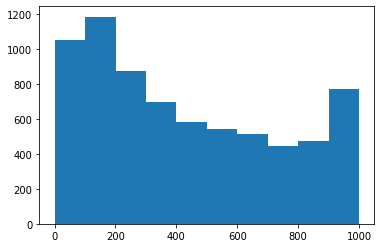

In [25]:
plt.hist(AIS_filtered["CPA"])
plt.show()

In [14]:
pd.set_option('display.max_columns', 500)

array(['2015-01-15T00:00:00.000000000', '2015-02-15T00:00:00.000000000',
       '2015-03-15T00:00:00.000000000', '2015-04-15T00:00:00.000000000',
       '2015-05-15T00:00:00.000000000', '2015-06-15T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-08-15T00:00:00.000000000',
       '2015-09-15T00:00:00.000000000', '2015-10-15T00:00:00.000000000',
       '2015-11-15T00:00:00.000000000', '2015-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')

'2015-02-15T00:00:00.000000000'

In [3]:
uniquedays_writ = np.array(['2015-12-15T00:00:00.000000000', '2015-01-15T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-02-15T00:00:00.000000000',
       '2015-11-15T00:00:00.000000000', '2015-04-15T00:00:00.000000000',
       '2015-10-15T00:00:00.000000000', '2015-03-15T00:00:00.000000000',
       '2015-05-15T00:00:00.000000000', '2015-08-15T00:00:00.000000000',
       '2015-06-15T00:00:00.000000000', '2015-09-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
uniquedays_writ.sort()

In [20]:
### Find the relevant days

files = glob.glob("/users/arnsteinvestre/code/Parquet/*.parquet")

pqdataset = pq.ParquetDataset(files)
AIS_df = pqdataset.read(columns = ["Timestamp"])

AIS_pdf = AIS_df.to_pandas()
uniquedays = AIS_pdf["Timestamp"].dt.normalize().unique()

In [12]:
### Read whole table

files = glob.glob("/users/arnsteinvestre/code/Parquet/*.parquet")
cols = ["Timestamp", "MMSI-nummer", "Longitude", "Latitude", "Speed_over_ground", "Course_over_ground", "Length", "Navigational_status", "Risk_category", "Width"]
pqdataset = pq.ParquetDataset(files)
AIS_df = pqdataset.read(columns = cols)
AIS_pd = AIS_df.to_pandas()


/anaconda/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
AIS_df

,Timestamp,IMO,MMSI-nummer,Longitude,Latitude,Speed_over_ground,Course_over_ground,Length,Navigational_status,Risk_category,Risk_category_name,Width,Heading,Ship_cargo_type_ID
0,2015-01-15 11:06:54,9543536,373090000,4.32561,60.8712,2.9,108.3,NaN,0,14,Crude oil tankers,42.037,157,1.0
1,2015-01-15 16:05:09,6903034,258445000,7.40434,62.7442,0.0,101.3,NaN,5,5,General cargo ships,10.090,511,NaN
2,2015-01-15 03:07:16,7505499,257583600,5.25856,59.4120,0.0,28.0,NaN,3,13,Fishing vessels,0.000,511,NaN
3,2015-01-15 01:30:29,9438963,258088000,5.73936,58.9723,0.0,12.0,NaN,5,16,Passenger ships,0.000,22,NaN
4,2015-01-15 17:00:41,9237993,258226000,5.58628,59.0435,13.3,134.4,NaN,0,16,Passenger ships,0.000,511,NaN
5,2015-01-15 21:32:55,9573074,253525000,11.33160,59.1154,0.0,211.6,NaN,0,12,Other activities,0.000,136,NaN
6,2015-01-15 06:07:47,9563172,258359500,18.90260,69.6156,31.2,219.8,NaN,0,16,Passenger ships,0.000,220,NaN
7,2015-01-15 16:45:32,9660449,258729000,8.48698,63.3885,14.7,245.3,NaN,0,12,Other activities,0.000,245,NaN
8,2015-01-15 09:21:13,8130693,273431330,143.51200,52.7209,0.6,147.0,NaN,0,10,Offshore supply ships,17.580,42,NaN
9,2015-01-15 15:34:18,9544542,257430000,5.29099,62.2613,10.4,55.5,NaN,0,12,Other activities,15.010,58,NaN


In [13]:
AIS_pd

,Timestamp,MMSI-nummer,Longitude,Latitude,Speed_over_ground,Course_over_ground,Length,Navigational_status,Risk_category,Width
0,2015-12-15 05:30:24,259199000,6.13294,62.4725,0.0,186.6,NaN,0,12,0.000
1,2015-12-15 07:42:02,273326830,14.35210,77.7188,4.8,175.4,NaN,0,13,13.520
2,2015-12-15 08:41:00,257338000,5.89232,59.1435,28.8,162.9,NaN,0,16,0.000
3,2015-12-15 16:42:34,257089000,1.89366,59.7455,8.6,78.6,NaN,15,13,0.000
4,2015-12-15 10:30:17,257340400,9.43692,63.6588,0.0,243.3,NaN,0,16,9.500
5,2015-12-15 04:06:53,257390000,2.11535,60.4999,0.1,315.9,NaN,0,13,7.350
6,2015-12-15 18:23:15,725000984,-73.48200,-43.2995,7.7,175.5,NaN,0,12,13.774
7,2015-12-15 19:56:34,273421520,17.63180,74.6824,4.4,235.2,NaN,15,13,0.000
8,2015-12-15 02:59:04,257173000,17.41280,68.4328,0.0,18.7,NaN,0,12,11.410
9,2015-12-15 06:08:41,259859000,5.07099,60.7925,0.0,314.4,NaN,5,5,11.490
